In [8]:
%matplotlib inline

import sys,os,time
import numpy as np
import matplotlib.pyplot as plt
import tables as tb
import yaml
from IPython.display import display, clear_output

#sys.path.append('../../../graphs/lib')
#import ccpdTools
#sys.path.append('../../../monopix/monopix_thinn')
import monopix_daq.analysis.interpreter_idx
import monopix_daq.monopix
m=monopix_daq.monopix.Monopix(no_power_reset=True)

In [17]:
!mkdir -p ./test

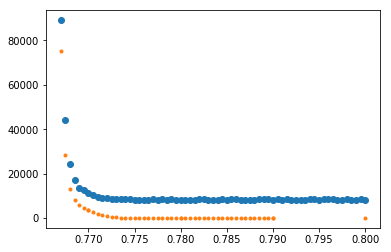

2019-06-03 12:10:37,098 - root - [INFO    ] (MainThread) stop_monoread:lost_cnt=0
2019-06-03 12:10:37,100 - root - [INFO    ] (MainThread) stop_timestamp640:src=tlu lost_cnt=0
2019-06-03 12:10:37,102 - root - [INFO    ] (MainThread) stop_timestamp640:src=inj lost_cnt=0
2019-06-03 12:10:37,104 - root - [INFO    ] (MainThread) stop_timestamp640:src=rx1 lost_cnt=0
2019-06-03 12:10:37,107 - root - [INFO    ] (MainThread) stop_timestamp640:src=mon lost_cnt=0


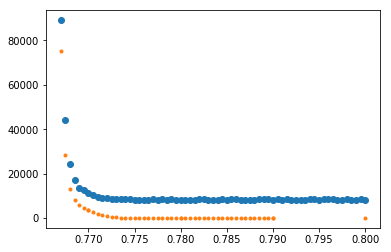

In [20]:
#### taking data
outdir="./test"
col=10
row=66
row_ref=65
m.set_global(Vfs=32)

m.set_inj_all(inj_high=1.1,inj_low=0.1,inj_n=0)
m.start_inj()

m.set_tdac(15)
tdac=m.get_tdac_memory()
tdac[col,row]=0
m.set_tdac(tdac)
m.set_inj_en("none")
m.set_preamp_en([[col,row],[col,row_ref]])

m.set_mon_en("none")
data=[]
cnt3=[]
th=0.8
th_e=0.60
th_s=-0.01
th3=[]
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
while th>th_e:
    m.set_th(th)
    m.set_monoread()
    m.set_timestamp640(src="inj")
    time.sleep(0.5)
    raw=m.get_data_now()
    data.append({"th":th,"raw":raw})
    
    ## plot
    cnt3.append(len(raw[(raw&0xC0000000)==0x0000000]))
    th3.append(th)
    clear_output(wait=True)
    ax.cla()
    ax.plot(th3,cnt3,"o")
    display(fig)
    
    if np.abs(th_s)>0.001 and cnt3[-1] > 0:
        th=th-th_s*2
        th_s=-0.0005
        th_b=th
    elif cnt3[-1]>60000: 
        break
    else:
        th=th+th_s
np.save(os.path.join(outdir,"%d-%dnone.npy"%(col,row)),data)
flist=[os.path.join(outdir,"%d-%dnone.npy"%(col,row))]
m.stop_all_data()

m.set_inj_en([col,65])    
data=[]
cnt4=[]
th4=[]
th=th_b+0.01
while th > th_e:
    m.set_th(th)
    m.set_monoread()
    m.set_timestamp640(src="inj")
    time.sleep(0.5)
    raw=m.get_data_now()
    data.append({"th":th,"raw":raw})
    
    ## plot
    cnt4.append(len(raw[raw&0xC0000000==0x0000000]))
    th4.append(th)
    clear_output(wait=True)
    ax.cla()
    plt.plot(th4,cnt4,'o')
    plt.plot(th3,cnt3,'.')
    display(fig)

    if cnt4[-1]>70000: 
        break
    else:
        th=th+th_s
np.save(os.path.join(outdir,"%d-%dinj.npy"%(col,row)),data)
flist.append(os.path.join(outdir,"%d-%dinj.npy"%(col,row)))
m.stop_all_data()

Text(0.5,1,'Inj=[10,65], HitOcc=[10,66]')

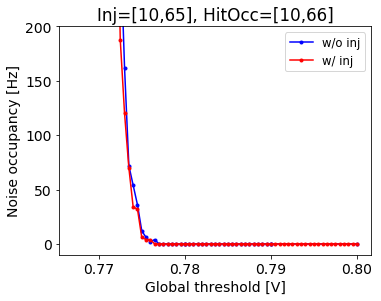

In [45]:
#### analysis

ccpdTools.img_size(0.7,0.7)
label=['w/o inj','w/ inj']
c=["b",'r']
fig,ax=plt.subplots(1,1)
interpreter=monopix_daq.analysis.interpreter_idx.InterRawIdx()
ccpdTools.img_size(0.7,0.7)
for i,fname in enumerate(flist):
    with open(fname) as f:
        dat=np.load(f)
    cnt=np.zeros(len(dat))
    th=np.empty(len(dat))
    for d_i,d in enumerate(dat):
        hit=interpreter.run(d['raw'])
        if len(hit)!=0:
            hit=hit[np.bitwise_and(hit['col']==col,hit['row']==row)]
            cnt[d_i]=len(hit)
        th[d_i]=d['th']
    arg=np.argsort(th)
    th=th[arg]
    cnt=cnt[arg]
    ax.plot(th,cnt/0.5,"%s.-"%c[i],label=label[i])

ax.set_ybound(-10,200)
ax.legend(loc="upper right")
ax.set_ylabel("Noise occupancy [Hz]")
ax.set_xlabel("Global threshold [V]")
ax.set_title("Inj=[%d,%d], HitOcc=[%d,%d]"%(col,row_ref,col,row))